# 0. Reading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 100)

In [2]:
file_paths = {'in':'../../data/processed/activity_log.csv'
             }

In [3]:
df = pd.read_csv(file_paths['in'])

In [4]:
df.head()

,ride_id,ride_date,elapsed_time,distance,bike_weight,moving_time,max_speed,avg_speed,elevation_gain,elevation_loss,elevation_low,elevation_high,max_grade,avg_grade,avg_power,calories,perceived_exertion,perceived_relative_effort,weather_observation_time,weather_temperature,apparent_temperature,humidity,weather_pressure,wind_speed,wind_gust,wind_bearing,sunrise_time,sunset_time,act_name_len,has_description,simple_exertion
0,2975587283,2020-01-02 14:02:58,1642,8.49,15.8757,1411,9.0,6.023033,19.557501,NaN,220.199997,231.500000,5.300000,-0.005883,NaN,NaN,7.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,True,HARD
1,2992935347,2020-01-08 13:20:26,1728,8.42,15.8757,1472,14.2,5.725408,46.301785,NaN,217.899994,242.800003,5.300000,0.224258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,True,NaN
2,2994399692,2020-01-08 22:08:17,1608,8.52,15.8757,1481,11.4,5.756246,26.526310,NaN,217.899994,242.899994,16.700001,-0.218182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,True,NaN
3,3248077156,2020-04-02 21:38:02,5143,10.36,15.8757,2544,13.4,4.074764,72.450409,55.750401,241.500000,277.100006,32.099998,0.161101,NaN,NaN,5.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,False,NORMAL
4,3255473930,2020-04-04 17:23:43,9348,34.95,15.8757,6356,14.4,5.498946,105.704369,106.103996,263.200012,306.000000,27.900000,-0.001144,NaN,NaN,5.0,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,True,NORMAL


In [5]:
# Ensure that the timestamp columns are datetime objects, not strings
make_timestamp = lambda x: pd.to_datetime(x)
time_cols = ['ride_date', 'weather_observation_time', 'sunrise_time', 'sunset_time']

for column in time_cols:
    df[column] = make_timestamp(df[column])


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ride_id                    226 non-null    int64         
 1   ride_date                  226 non-null    datetime64[ns]
 2   elapsed_time               226 non-null    int64         
 3   distance                   226 non-null    float64       
 4   bike_weight                226 non-null    float64       
 5   moving_time                226 non-null    int64         
 6   max_speed                  226 non-null    float64       
 7   avg_speed                  226 non-null    float64       
 8   elevation_gain             223 non-null    float64       
 9   elevation_loss             223 non-null    float64       
 10  elevation_low              226 non-null    float64       
 11  elevation_high             226 non-null    float64       
 12  max_grad

# 1. Rides over Time

In [9]:
# Create the distance over time dataframe
# 1. Ensure we are in miles for the best intuition
km2mi = 0.621371
df_distance = df[['ride_date','distance']].copy()
df_distance['distance_mi'] = km2mi * df['distance']

# 2. Make sure the datetime column is the index
df_distance = df_distance.set_index('ride_date').sort_index()

In [10]:
# 2. Resample the distance travelled in a daily period
# helpful reference: https://www.youtube.com/watch?v=l4dvMiSDBzs
# We want LEFT closed-ness and labels since we want all data between [date k 00:00:00, date k+1 00:00:00)
df_distance = df_distance.resample('D', closed='left', label='left').sum()
df_distance.shape

(729, 2)

In [11]:
# 3. Get rid of the 0 sum entries that bloated the dataframe. (We don't want to plot them)
filt_zero_distance = df_distance.loc[:,'distance_mi'] == 0.0
df_distance = df_distance.loc[~filt_zero_distance, :]

# 4. Reset the Index for plotting
df_distance = df_distance.reset_index()

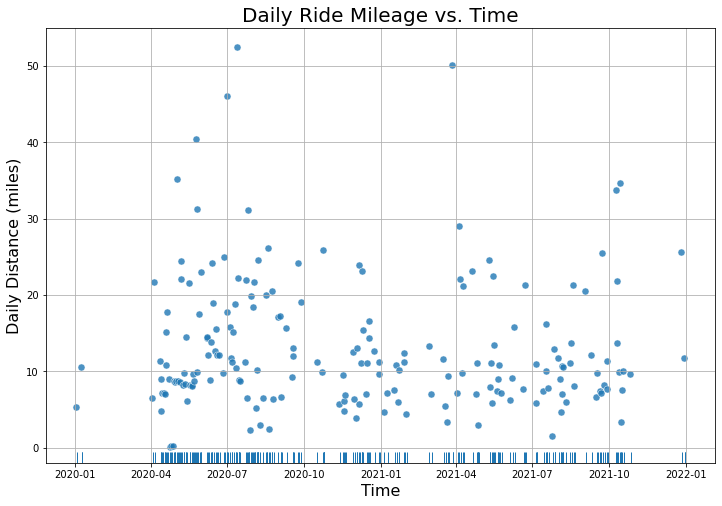

In [12]:
fig = plt.figure(figsize=(12,8))
_ = sns.scatterplot(x='ride_date', y='distance_mi', data=df_distance, s=50, alpha=0.8)
_ = sns.rugplot(x='ride_date', data=df)
_ = plt.grid()
_ = plt.ylim([-2, 55])
_ = plt.title('Daily Ride Mileage vs. Time', fontsize=20)
_ = plt.xlabel('Time', fontsize=16)
_ = plt.ylabel('Daily Distance (miles)', fontsize=16)

# 2. Ride Difficulty over Time

In [13]:
df['distance_mi'] = km2mi * df['distance']

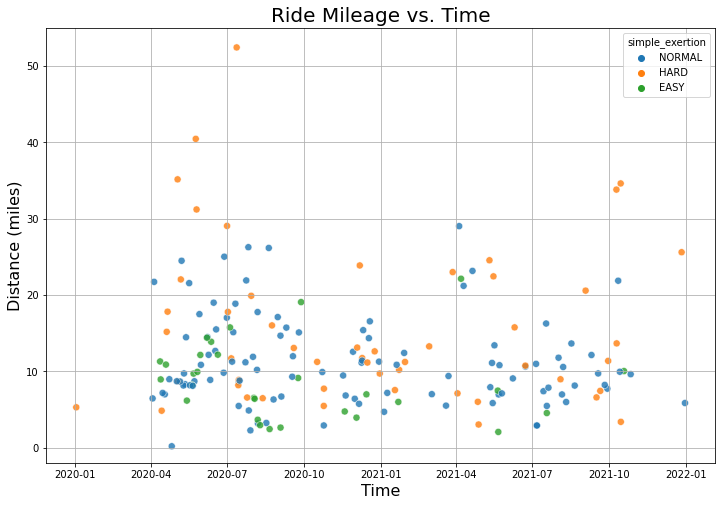

In [17]:
fig = plt.figure(figsize=(12,8))
_ = sns.scatterplot(x='ride_date', y='distance_mi', data=df.sample(frac=1, random_state=42), s=50, 
                    alpha=0.8, hue='simple_exertion')
_ = plt.grid()
_ = plt.ylim([-2, 55])
_ = plt.title('Ride Mileage vs. Time', fontsize=20)
_ = plt.xlabel('Time', fontsize=16)
_ = plt.ylabel('Distance (miles)', fontsize=16)